In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Semantic Segmentation/Dataset" "/content/Dataset"

Mounted at /gdrive
ln: failed to create symbolic link '/content/Dataset/Dataset': File exists


In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
path = '/content/Dataset/'
image_path = os.path.join(path, 'CameraRGB/')
mask_path = os.path.join(path, 'CameraSeg/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [ ]:
image_list = sorted(image_list)
mask_list = sorted(mask_list)

In [ ]:
len(image_list)

1000

In [ ]:
len(mask_list)

1000

Text(0.5, 1.0, 'Segmentation')

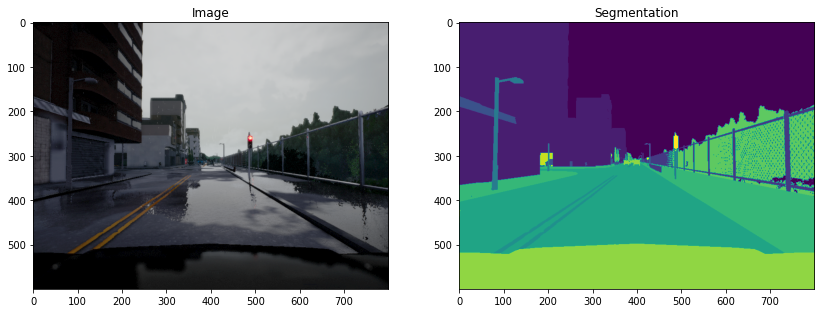

In [ ]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/Dataset/CameraRGB/02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/Dataset/CameraSeg/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/Dataset/CameraRGB/02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/Dataset/CameraSeg/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/Dataset/CameraRGB/02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/Dataset/CameraSeg/02_00_010.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/Dataset/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/content/Dataset/CameraSeg/02_00_000.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

(600, 800, 1)


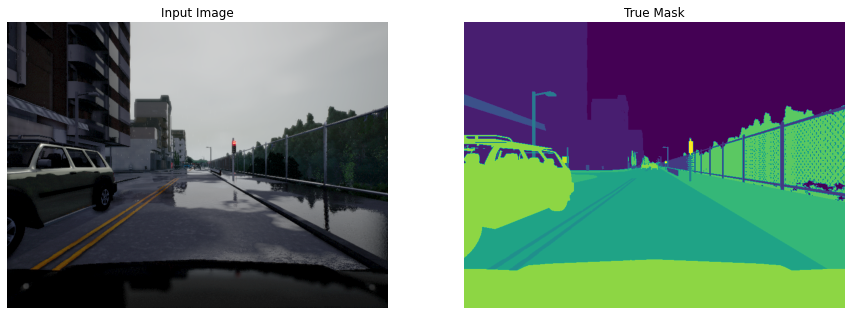

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


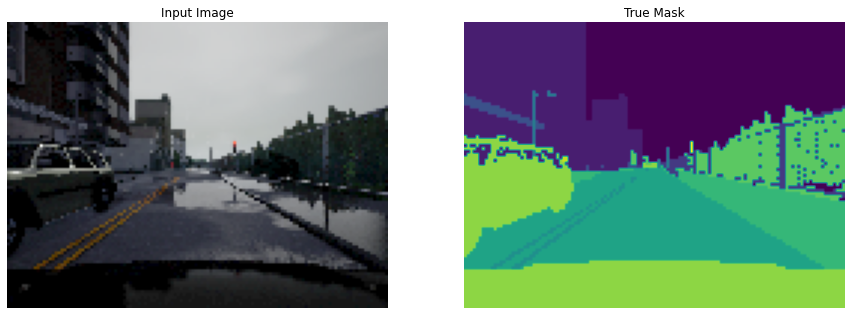

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters, 
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, 
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)         
        
    if max_pooling:
        next_layer = MaxPooling2D(2, strides=2)(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    
                 3,
                 strides=2,
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, 
                  3,  
                  activation= 'relu',
                  padding= 'same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, 
                  3,
                  activation= 'relu',
                  padding= 'same',
                  kernel_initializer= 'he_normal')(conv) 
        
    return conv

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs= inputs, n_filters=n_filters*1)
    cblock2 = conv_block(inputs= cblock1[0], n_filters= n_filters*2)
    cblock3 = conv_block(inputs= cblock2[0], n_filters= n_filters*4)
    cblock4 = conv_block(inputs= cblock3[0], n_filters= n_filters*8, dropout_prob= 0.3)
    cblock5 = conv_block(inputs= cblock4[0], n_filters= n_filters*16, dropout_prob= 0.3, max_pooling= False) 
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/20
32/32 [==============================] - 23s 381ms/step - loss: 0.3531 - accuracy: 0.8840
Epoch 2/20
32/32 [==============================] - 4s 133ms/step - loss: 0.3415 - accuracy: 0.8879
Epoch 3/20
32/32 [==============================] - 4s 133ms/step - loss: 0.3344 - accuracy: 0.8896
Epoch 4/20
32/32 [==============================] - 4s 133ms/step - loss: 0.3250 - accuracy: 0.8928
Epoch 5/20
32/32 [==============================] - 4s 134ms/step - loss: 0.3155 - accuracy: 0.8955
Epoch 6/20
32/32 [==============================] - 4s 134ms/step - loss: 0.3039 - accuracy: 0.8989
Epoch 7/20
32/32 [==============================] - 4s 134ms/step - loss: 0.2934 - accuracy: 0.9021
Epoch 8/20
32/32 [==============================] - 4s 134ms/step - loss: 0.2852 - accuracy: 0.9042
Epoch 9/20
32/32 [==============================] - 4s 134ms/step - loss: 0.28

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

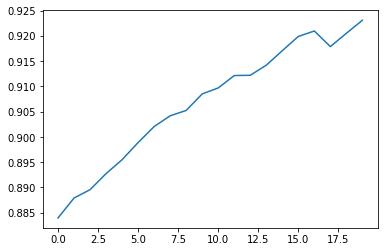

In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
def show_predictions(dataset=None, num=1):

    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 20ms/step


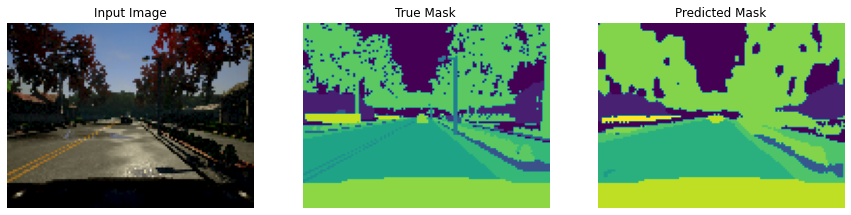

1/1 [==============================] - 0s 34ms/step


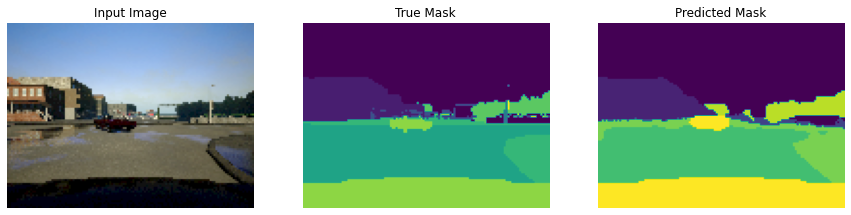

1/1 [==============================] - 0s 31ms/step


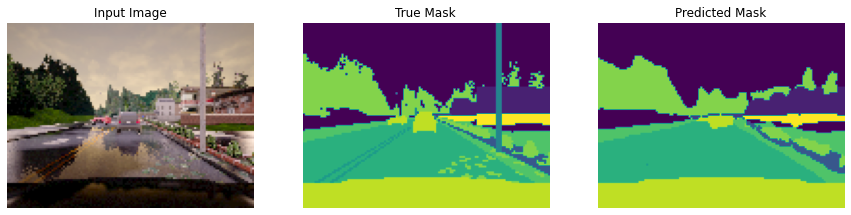

1/1 [==============================] - 0s 39ms/step


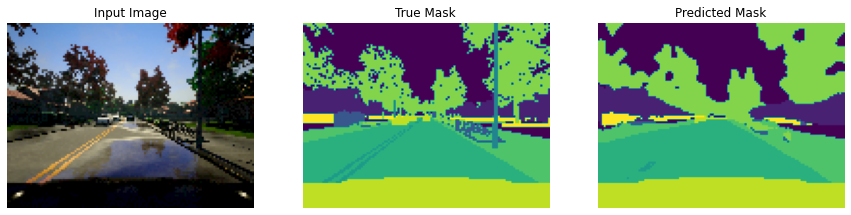

1/1 [==============================] - 0s 63ms/step


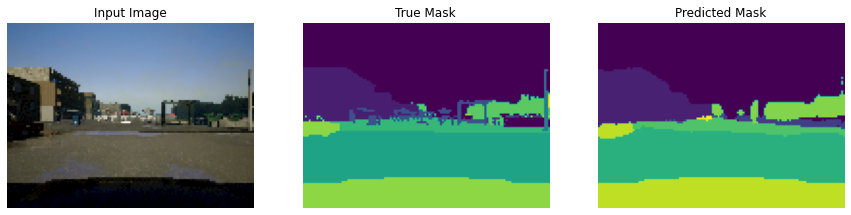

1/1 [==============================] - 0s 18ms/step


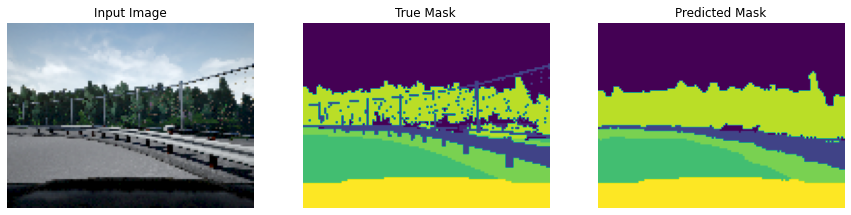

In [ ]:
show_predictions(train_dataset, 6)